In [1]:
import os
import traceback
import numpy as np
from numpy import linalg as LA

from hyperbolicTSNE import Datasets
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, write_data, store_visuals
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


# Dataset generation code
Generate a specific set of samples we want to use.
Right now we want 10 samples of data with labels 2 and 4.

In [2]:
# MNIST DATA 

# n_samples = 20             # How much to sample from each class
# dataX, dataLabels = load_mnist(data_home=data_home)
# print(dataX.shape, dataLabels.shape)

# indices_2 = np.where(dataLabels == 2)
# indices_4 = np.where(dataLabels == 4)

# samples_idx_2 = np.random.choice(indices_2[0], size=n_samples, replace=False)
# samples_idx_4 = np.random.choice(indices_4[0], size=n_samples, replace=False)

# print(samples_idx_2)
# print(samples_idx_4)

# print(dataLabels[samples_idx_2])
# print(dataLabels[samples_idx_4])

# labels_2 = dataLabels[samples_idx_2]
# labels_4 = dataLabels[samples_idx_4]
# sample_labels = np.concatenate((labels_2, labels_4), axis=0)

# samples_2 = dataX[samples_idx_2]        # samples of number 2
# samples_4 = dataX[samples_idx_4]        # samples of number 4
# sample_data = np.concatenate((samples_2, samples_4), axis=0)    # Contains both 2 and 4 

# print(sample_data.shape)    

In [3]:
from scipy.stats import multivariate_normal

def generate_linear_hierarchical_data(n_samples, n_clusters, n_dim, start, end):
    """ 
    Generate a "hierarchical" dataset where we basically generate clusters from "left" to "right" 
    """
    # n_samples must be a integer multiple of n_clusters
    points_per_cluster = n_samples
    cluster_distances = np.abs(end - start) / n_clusters                            # distance between each cluster
    cluster_centers = [start + i * cluster_distances for i in range(n_clusters)]    # centers of each cluster

    # Generate data
    data = []
    for center in cluster_centers:
        cluster_center = np.ones(n_dim) * center
        #cluster_cov = np.identity(n_dim) * (cluster_distances ** 2)
        cluster_cov = np.identity(n_dim)
        cluster_data = multivariate_normal.rvs(mean=cluster_center, cov=cluster_cov, size=points_per_cluster)
        data.append(cluster_data)

    # Generate labels
    labels = []
    for i in range(n_clusters):
        labels = labels + [i for _ in range(points_per_cluster)]

    return np.array(data), np.array(labels)


# Custom data, Uniform distrib.
from scipy.stats import uniform 
def generate_uniform_clusters(n_samples, n_dim, b1, b2):
    # n_samples = 500
    # n_dim = 10
    # b1 = 1000000
    # b2 = 100

    # Bounds for first distribution
    lb_1 = np.ones(n_dim) * (-b1)
    ub_1 = np.ones(n_dim) * (-b2)
    widths_1 = ub_1 - lb_1 

    # Bounds for 2nd distribution
    lb_2 = np.ones(n_dim) * b2
    ub_2 = np.ones(n_dim) * b1
    widths_2 = ub_2 - lb_2

    # Draw samples 
    samples_1 = uniform.rvs(loc=lb_1, scale=widths_1, size=(n_samples, n_dim))
    samples_2 = uniform.rvs(loc=lb_2, scale=widths_2, size=(n_samples, n_dim))

    dataX = np.concatenate((samples_1, samples_2), axis=0)
    labels = [0 for _ in range(n_samples)] + [1 for _ in range(n_samples)]
    dataLabels = np.array(labels)

    return dataX, dataLabels

# Preperation for running embedding
Get the distance matrix and affinity matrix of our samples

In [4]:
n_samples = 5
n_clusters = 2
n_dim = 2
start = 0
end = 100

dataX, dataLabels = generate_linear_hierarchical_data(n_samples, n_clusters, n_dim, start, end)
dataX = dataX.reshape((dataX.shape[0] * dataX.shape[1], dataX.shape[2]))

In [5]:
hd_params = {"perplexity": n_samples}
D, V = hd_matrix(X=dataX, D=None, V=None,
                    knn_method="sklearn", metric="euclidean", n_neighbors=n_samples, knn_params=None,
                    hd_method="vdm2008", hd_params=hd_params, verbose=1)

Computing the kNN D matrix with k=9 nearest neighbors...
Using sklearn NearestNeighbor, an exact method, for the knn computation
Indexed 10 samples in 0.001s...
Computed neighbors for 10 samples in {duration:.3f}s...
`hd_method` set to `vdm2008`, running with perplexity 5. Returns (D, V)
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 39.437431


Initialize configuration parameters and stuff

In [6]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots
grad_path = "temp/grad/"

seed = 42

dataset = Datasets.MNIST
num_points = [-1]
perplexities = [50]
correct_gradients = [True, False]                # NOTE: Recompile with correct flag (GRAD_FIX flag)
exact = True                                     # Exact computation or BH estimation of gradient
pca_components = 0                               # Whether to use pca initialization of high dim. data or not
grad_scale_fix = True                            # Whether we multiply the gradient by the inverse metric tensor of hyperbolic space or not
                                                 # Note that the correct hyperoblic gradient has an inverse metric tensor factor

# Simple experiment with no exaggeration
exaggeration_factor = 12
ex_iterations = 0
main_iterations = 1000
cf = HyperbolicKL

# Run embedding
Code below runs the embedding procedure for our specified dataset

In [7]:
for correct_gradient in correct_gradients:
    print(f"Experiment with grad_fix:{correct_gradient}")

    # Compute initial embedding in Poincare disk (PCA embedding)
    X_embedded = initialization(
        n_samples=dataX.shape[0], 
        n_components=2,
        X=dataX,
        random_state=seed,
        method="random"
    ) 

    # Initialize config and parameters
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 

    log_path_cf = log_path + f"correct_grad:{correct_gradient}/"
    grad_path_grad = grad_path + f"correct_grad:{correct_gradient}/"
    
    opt_params, opt_conf = initialize_logger(opt_params, opt_conf, log_path_cf, grad_path_grad)
    opt_params["cf_params"].update({"grad_fix" : correct_gradient})     # So the cost function knows which gradient to use
    
    # Set up H-TSNE object 
    htsne = HyperbolicTSNE(
        init=X_embedded, 
        n_components=2, 
        metric="precomputed", 
        verbose=1, 
        opt_method=SequentialOptimizer,         # the optimizater we use
        opt_params=opt_params              # the parameters for the optimizers
    )

    # Compute embedding:
    try:
        hyperbolicEmbedding = htsne.fit_transform((D, V))
        
    except ValueError:
        hyperbolicEmbedding = find_last_embedding(log_path)
        traceback.print_exc()

    # Store visuals
    # save_folder = "results/gradient_vis_images"
    # file_name = f"{save_folder}/gradienttesting_correctgrad:{correct_gradient}"
    # store_visuals(hyperbolicEmbedding, dataLabels, save_folder, file_name, opt_params)

Experiment with grad_fix:True
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.0008333333333333334, 'learning_rate_main': 0.0008333333333333334, 'exaggeration': 12, 'exaggeration_its': 0, 'gradientDescent_its': 1000, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': True}
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent: 0it [00:00, ?it/s]


Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 0.00040 grad_norm: 3.17536e-04: 100%|██████████| 1000/1000 [00:01<00:00, 791.78it/s]


Experiment with grad_fix:False
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.0008333333333333334, 'learning_rate_main': 0.0008333333333333334, 'exaggeration': 12, 'exaggeration_its': 0, 'gradientDescent_its': 1000, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': False}
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent: 0it [00:00, ?it/s]


Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 0.16374 grad_norm: 9.81621e-02: 100%|██████████| 1000/1000 [00:01<00:00, 763.72it/s]


# Gradient analysis notes:

- Upon preliminary observations, the true gradient tends to push embeddings towards the outer edge much more than the wrong gradient. 

- The correct gradient needs a bit of time before it starts moving the points outwards. The incorrect one starts moving faster.

- Possible explanation: 
$d^H_{ij}$ amplifies all the forces. The $F_{rep}$ force for points that are far away always contributes to the gradient because the t-distribution has heavy tails, so if points are already far away, they still have a considerable effect on eachother. 
[Analyze repulsive forces contribution?]

- Things to try to get a sense of the differences in gradients? Plot norms, plot difference in norms, ...


# Experiment (1)
Experiment to test the code and some preliminary data analysis of the gradients

/var/folders/07/ch9mvbbd7fz00ftfgrw31vwh0000gn/T/ipykernel_3903/1228736952.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


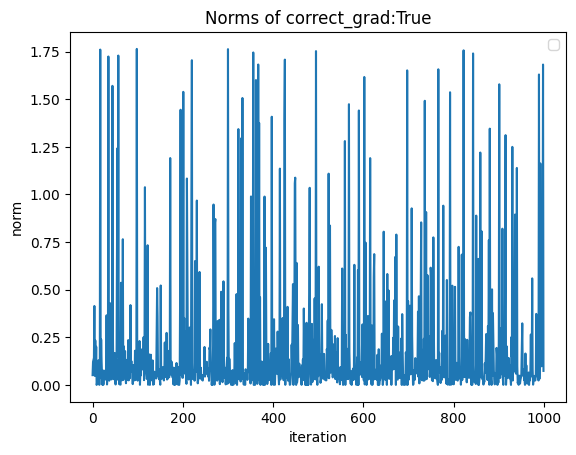

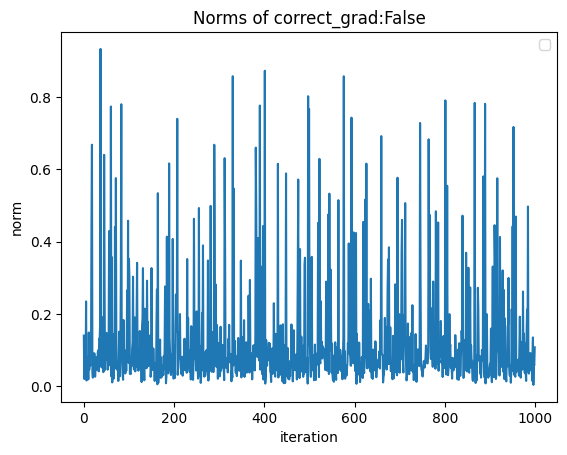

In [8]:
# Gradient analysis code. NOTE: Currently we only take into account the first entry (1 datapoint)
# Comparison of norm of gradients
import pandas as pd
import csv
from pathlib import Path 
import matplotlib.pyplot as plt

all_norms = []
# Read gradients from file
for correct_gradient in correct_gradients:
    folder_path = Path(f"temp/grad/correct_grad:{correct_gradient}")
    norms = []

    # After opening folder_path we encounter 2 more folders for the different optimizer results
    for optim_folder in folder_path.iterdir():

        # Open the folder and iterate over csvs
        for csv_file_path in optim_folder.iterdir():
            with csv_file_path.open('r') as file:
                reader = csv.reader(file)                               
                first_line = next(reader)
                grad = np.array([float(val) for val in first_line])     # convert read strings to float
                norms.append(LA.norm(grad))                             # compute norm and store value

    # Plot the norms
    norms = np.array(norms)
    idxs = np.array([i for i in range(norms.shape[0])])
    all_norms.append(norms)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the data
    ax.plot(idxs, norms)

    # Add labels and title
    ax.set_xlabel('iteration')
    ax.set_ylabel('norm')
    ax.set_title(f'Norms of correct_grad:{correct_gradient}')
    ax.legend()

    # Show the plot
    plt.show()

/var/folders/07/ch9mvbbd7fz00ftfgrw31vwh0000gn/T/ipykernel_3903/2895653599.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


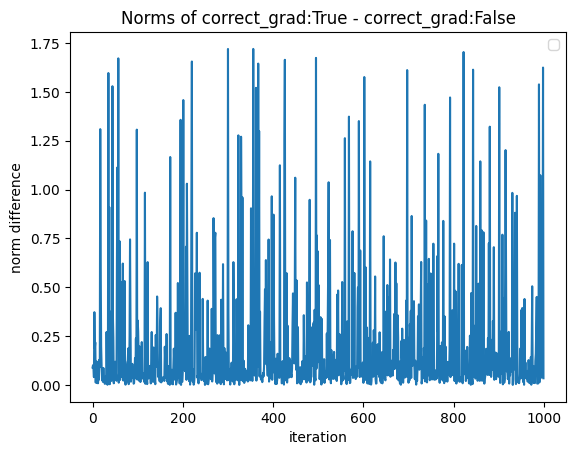

In [9]:
# Norm difference of [correct gradients] - [incorrect gradients]
norm_difference = np.abs(all_norms[0] - all_norms[1])
idxs = np.array([i for i in range(norm_difference.shape[0])])

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(idxs, norm_difference)

# Add labels and title
ax.set_xlabel('iteration')
ax.set_ylabel('norm difference')
ax.set_title(f'Norms of correct_grad:{True} - correct_grad:{False}')
ax.legend()

# Show the plot
plt.show()

# Experiment (2)
Compute both gradients for the same embeddings. Choice of embedding should be set manually

In [36]:
from gradient_experiments import GradientComparisons
from pathlib import Path

embedding_folder_path = "temp/poincare/correct_grad:True"              # Where our embeddings are 
output_folder_path = "results/gradient_comparisons"                    # Where to store our results
V = V                                                                   # High dim. affinity matrix, precomputed

# For each type of gradient, calculate the gradients and stor # the results
for correct_gradient in correct_gradients:
    # Initialize config and parameters
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 
    opt_params["cf_params"].update({"grad_fix" : correct_gradient})         # So the cost function knows which gradient to use
    params = opt_params["cf_config_params"] | opt_params["cf_params"]       # Params to initialize cf

    key = f"linear_hierarchical_data_nclusters:{n_clusters}_ndata:{n_samples}"
    cf = HyperbolicKL(n_components=2, other_params=params)                  
    
    # Run experiment
    Experiment_Gradients = GradientComparisons(embedding_folder_path, cf, key)  
    Experiment_Gradients.compute_gradients(V, correct_gradient, output_folder_path)

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
